In [23]:
import pandas as pd
import matplotlib.pyplot as plt

In [12]:
from nltk.util import ngrams
from nltk.tokenize import TweetTokenizer, sent_tokenize
import numpy as np
import nltk
import collections

class Text():

    def __init__(self, text, author):
        self.author = author
        self.text = text.lower()
        self.tokens = TweetTokenizer().tokenize(self.text)
        self.sentences = sent_tokenize(self.text)
        self.total_number_of_tokens = len(self.tokens)
        self.max_ngrams = 1
        self.vector = self.get_vector()

    def get_vector(self):
        vector = {}
        vector.update( {'original_book_author': self.author } )
        vector.update( self.word_gram_data() )
        vector.update( self.pos_gram_data() )
        vector.update( self.stylometric_data() )
        return vector

    def count_map(self, items):
        count_map = {}
        for item in items:
            if item in count_map:
                count_map[item] += 1
            else:
                count_map[item] = 1
        return count_map

    def percentage_map(self, count_map, total):
        return( { key : (lambda count: count / total)(count) for ( key, count ) in count_map.items() } )

    def word_gram_data(self):
        output_dictionary = {}
        for n in range(1, self.max_ngrams + 1):
            n_grams = ngrams(self.tokens, n)
            all_grams = list(n_grams)
            total = len(all_grams)
            grams_collection = collections.Counter(all_grams)
            grams_collection = dict(grams_collection)

            for ngram, count in grams_collection.items():
                output_dictionary[" ".join(ngram)] = count/total

        return output_dictionary

    def pos_gram_data(self):
        output_dictionary = {}
        pos_tags = nltk.pos_tag(self.tokens)
        pos_tags = [pos[1] for pos in pos_tags]

        for n in range(1, self.max_ngrams + 1):
            n_grams = ngrams(pos_tags, n)
            all_grams = list(n_grams)
            total = len(all_grams)
            grams_collection = collections.Counter(all_grams)
            grams_collection = dict(grams_collection)

            for ngram, count in grams_collection.items():
                output_dictionary[" ".join(ngram)] = count/total

        return output_dictionary

    def word_lengths(self):
        word_lengths = []
        forbidden = [".", ",", "?", "!", "\"","\'",";",":"]
        for word in self.tokens:
            if word not in forbidden:
                word_lengths.append(len(word))
        return sorted(word_lengths)

    def stylometric_data(self):
        output = self.word_length_data()
        output.update(self.sentence_length_data())
        output.update(self.word_richness())
        return output

    def sentence_lengths(self):
        sentence_lengths = []
        for sentence in self.sentences:
            sentence_lengths.append(len(sentence.split(" ")))
        return sorted(sentence_lengths)

    def word_length_distr(self):
        word_lengths = self.word_lengths()
        return self.percentage_map( self.count_map(word_lengths), len(word_lengths) )

    def sentence_lengths_distr(self):
        sentence_lengths = self.sentence_lengths()
        return self.percentage_map( count_map(sentence_lengths), len(sentence_lengths) )

    def word_length_data(self):
        word_lengths = self.word_lengths()
        #self.row.update( {'word_length_avg': np.mean(word_lengths),'word_length_std_dev': np.std(word_lengths)} )
        return ( {'word_length_avg': np.mean(word_lengths),'word_length_std_dev': np.std(word_lengths)} )

    def sentence_length_data(self):
        sentence_lengths = self.sentence_lengths()
        # self.row.update( {'sentence_length_avg': np.mean(sentence_lengths), 'sentence_length_std_dev': np.std(sentence_lengths) })
        return ( {'sentence_length_avg': np.mean(sentence_lengths), 'sentence_length_std_dev': np.std(sentence_lengths) })

    def word_richness(self):
        # self.row.update( {'word_richness': len(self.tokens) / len(set(self.tokens)) } )
        return ( {'word_richness': len(self.tokens) / len(set(self.tokens)) } )

    def num_sentences(self):
        self.row.update( {'number_sentences': len(self.sentences)} )

if __name__ == '__main__':
    pass


In [13]:
import pandas as pd
from text_features import Text
import os
import csv
import numpy as np

class Matrix():

    def __init__(self, authors):
        path = "data/texts_cleaned"
        self.matrix = pd.DataFrame()
        self.authors = authors
        self.build_matrix(path)


    def build_matrix(self, path):
        books = []
        index = []
        for author in self.authors:
            print(author)
            for book in os.listdir(path + '/' + author):
                print("\t", book)
                text = Text( open(path + '/' + author + '/' + book, 'r', errors='ignore').read(), author )
                # book = text.vector
                # print(book)
                books.append(text.vector)
                index.append(book)
                #self.matrix = self.matrix.append( pd.DataFrame(text.get_vector(), index=[book] ) )
        self.matrix = pd.DataFrame.from_records(books, index = index)

        print("features retrieved")
        self.matrix = self.matrix.fillna(0)
        self.matrix.to_csv("wirt_test_pre_sparcity.csv", encoding='utf-8')
        self.eliminate_sparse_columns(.5)
        self.matrix.to_csv("wirt_test_pre_significance.csv", encoding='utf-8')
        self.eliminate_non_significant_columns(.3)
        self.matrix.to_csv("wirt_test_complete.csv", encoding='utf-8')



    def eliminate_sparse_columns(self, threshold): # threshold -> min_percent_data
        # print("starting csv read")
        # self.matrix = pd.read_csv("./matrix_builder_full_table.csv", header=0, index_col=0)

        print("eliminate_sparce_columns_function")
        columns_to_keep = ['original_book_author', 'word_length_avg', 'word_length_std_dev', 'sentence_length_avg', 'sentence_length_std_dev', 'word_richness']
        feature_list = list( set(self.matrix.columns.values).difference( set( columns_to_keep ) ) )
        sparcity_data = pd.DataFrame(columns=self.authors, index=feature_list)

        for author in self.authors:
            print("\t", author)
            subframe = self.matrix.loc[self.matrix['original_book_author'] == author]
            for column in subframe:
                if column not in columns_to_keep:
                    subcolumn = subframe[column]
                    number_of_zeros = (subcolumn == 0).sum()
                    percent_data = (len(subcolumn) - number_of_zeros) / len(subcolumn)
                    sparcity_data.at[column, author] = percent_data

        sparcity_data = pd.DataFrame(data=sparcity_data.min(axis=1), columns=['min'])
        sparcity_data = sparcity_data[sparcity_data['min'] <= threshold]
        self.matrix = self.matrix.drop( sparcity_data.index, axis=1 )



    def eliminate_non_significant_columns(self, threshold):
        # print("starting csv read")
        # self.matrix = pd.read_csv("./matrix_builder_post_sparcity.csv", header=0, index_col=0)

        print('eliminate_non_significant_columns function')
        # Columns we want to avoid
        columns_to_keep = ['original_book_author', 'word_length_avg', 'word_length_std_dev', 'sentence_length_avg', 'sentence_length_std_dev', 'word_richness']
        # Make two tables for the means and std's by authors
        feature_list = list( set(self.matrix.columns.values).difference( set( columns_to_keep ) ) )
        mean_feature_data = pd.DataFrame(columns=self.authors, index=feature_list)
        std_feature_data = pd.DataFrame(columns=self.authors, index=feature_list)

        feature_data = pd.DataFrame(columns=['mean_of_stds','std_of_means'], index=feature_list)

        for author in self.authors:
            print("\t", author)
            subframe = self.matrix.loc[self.matrix['original_book_author'] == author]
            for column in subframe:
                if column not in columns_to_keep:
                    mean_feature_data.at[column, author] = np.mean(subframe[column])
                    std_feature_data.at[column, author] = np.std(subframe[column])

        print("\tsub tables built, constructing feature table")
        for column in feature_list:
            feature_data.at[column,'mean_of_stds'] = np.mean(std_feature_data.loc[column])
            feature_data.at[column,'std_of_means'] = np.mean(mean_feature_data.loc[column])

        print("\tdrops")
        drops = feature_data.sort_values(by=['mean_of_stds']).head( int(threshold * feature_data.shape[0]))
        self.matrix = self.matrix.drop( drops.index, axis=1 )
        drops = feature_data.sort_values(by=['std_of_means']).tail( int(threshold * feature_data.shape[1]))
        self.matrix = self.matrix.drop( drops.index, axis=1 )

if __name__ == '__main__':
    matrix = Matrix(['mildred_a._wirt','oscar_wilde'])


mildred_a._wirt
	 whispering_walls.txt
	 the_brownie_scouts_at_windmill_farm.txt
	 ghost_beyond_the_gate.txt
	 dan_carter_and_the_river_camp.txt
	 dan_carter_cub_scout.txt
	 swamp_island.txt
	 clue_of_the_silken_ladder.txt
	 voice_from_the_cave.txt
	 hoofbeats_on_the_turnpike.txt
	 the_secret_pact.txt
	 the_wishing_well.txt
	 the_brownie_scouts_and_their_tree_house.txt
	 dan_carter_and_the_cub_honor.txt
	 the_brownie_scouts_at_silver_beach.txt
	 saboteurs_on_the_river.txt
	 the_brownie_scouts_in_the_cherry_festival.txt
	 guilt_of_the_brass_thieves.txt
	 the_clock_strikes_thirteen.txt
	 signal_in_the_dark.txt
	 dan_carter_and_the_great_carved_face.txt
	 danger_at_the_drawbridge.txt
	 dan_carter_and_the_money_box.txt
	 dan_carter_and_the_haunted_castle.txt
	 behind_the_green_door.txt
oscar_wilde
	 a_critic_in_pall_mall.txt
	 selected_prose_of_oscar_wilde.txt
	 poems.txt
	 the_soul_of_man_under_socialism.txt
	 the_canterville_ghost.txt
	 the_duchess_of_padua.txt
	 charmides_and_other_poem

In [15]:
total_features = pd.read_csv("wirt_test_pre_sparcity.csv", header=0, index_col=0)

post_sparcity = pd.read_csv("wirt_test_pre_significance.csv", header=0, index_col=0)

post_significance = pd.read_csv("wirt_test_complete.csv", header=0, index_col=0)

In [19]:
wirt_complete_df = pd.DataFrame(columns = ["total", "post_sparcity", "post_significance"], index = ['wirt'] )

In [20]:
wirt_complete_df.at['wirt', "total"] = len(list(total_features.columns.values))
wirt_complete_df.at['wirt', 'post_sparcity'] = len(list(post_sparcity.columns.values))
wirt_complete_df.at['wirt', 'post_significance'] = len(list(post_significance.columns.values))

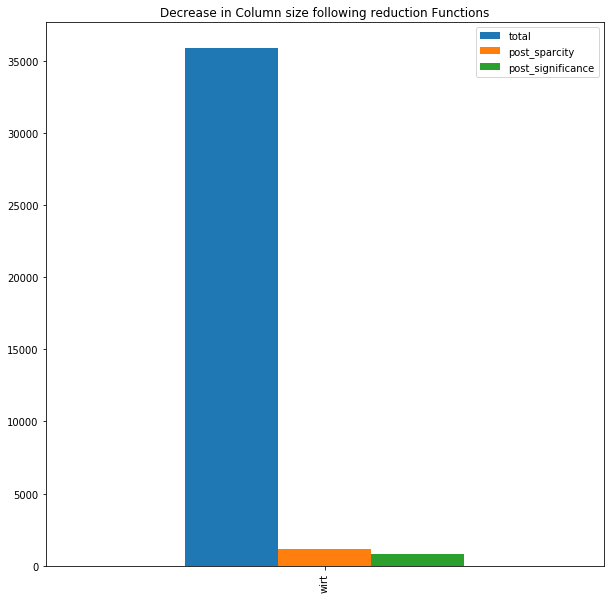

In [28]:
wirt_complete_df.plot.bar(figsize=(10,10), title='Decrease in Column size following reduction Functions')

In [58]:
differnces_table = pd.DataFrame(index=list(range(2,11)), columns=[total", "processed"])

In [33]:
two_authors_total = pd.read_csv("./2author1grams_post_sparcity.csv", header=0, index_col=0)
two_authors_processed = pd.read_csv("./2author1grams.csv", header=0, index_col=0)
three_authors_total = pd.read_csv("./3author1grams_post_sparcity.csv", header=0, index_col=0)
three_authors_processed = pd.read_csv("./3author1grams.csv", header=0, index_col=0)
four_authors_total = pd.read_csv("./4author1grams_post_sparcity.csv", header=0, index_col=0)
four_authors_processed = pd.read_csv("./4author1grams.csv", header=0, index_col=0)
five_authors_total = pd.read_csv("./5author1grams_post_sparcity.csv", header=0, index_col=0)
five_authors_processed = pd.read_csv("./5author1grams.csv", header=0, index_col=0)
six_authors_total = pd.read_csv("./6author1grams_post_sparcity.csv", header=0, index_col=0)
six_authors_processed = pd.read_csv("./6author1grams.csv", header=0, index_col=0)
seven_authors_total = pd.read_csv("./7author1grams_post_sparcity.csv", header=0, index_col=0)
seven_authors_processed = pd.read_csv("./7author1grams.csv", header=0, index_col=0)
eight_authors_total = pd.read_csv("./8author1grams_post_sparcity.csv", header=0, index_col=0)
eight_authors_processed = pd.read_csv("./8author1grams.csv", header=0, index_col=0)
nine_authors_total = pd.read_csv("./9author1grams_post_sparcity.csv", header=0, index_col=0)
nine_authors_processed = pd.read_csv("./9author1grams.csv", header=0, index_col=0)
ten_authors_total = pd.read_csv("./10author1grams_post_sparcity.csv", header=0, index_col=0)
ten_authors_processed = pd.read_csv("./10author1grams.csv", header=0, index_col=0)

In [57]:
# differnces_table.at[2, "differences"] = len(list(two_authors_total.columns.values)) - len(list(two_authors_processed.columns.values))
# differnces_table.at[3, "differences"] = len(list(three_authors_total.columns.values)) - len(list(three_authors_processed.columns.values))
# differnces_table.at[4, "differences"] = len(list(four_authors_total.columns.values)) - len(list(four_authors_processed.columns.values))
# differnces_table.at[5, "differences"] = len(list(five_authors_total.columns.values)) - len(list(five_authors_processed.columns.values))
# differnces_table.at[6, "differences"] = len(list(six_authors_total.columns.values)) - len(list(six_authors_processed.columns.values))
# differnces_table.at[7, "differences"] = len(list(seven_authors_total.columns.values)) - len(list(seven_authors_processed.columns.values))
# differnces_table.at[8, "differences"] = len(list(eight_authors_total.columns.values)) - len(list(eight_authors_processed.columns.values))
# differnces_table.at[9, "differences"] = len(list(nine_authors_total.columns.values)) - len(list(nine_authors_processed.columns.values))
# differnces_table.at[10, "differences"] = len(list(ten_authors_total.columns.values)) - len(list(ten_authors_processed.columns.values))

In [59]:
differnces_table.at[2, "total"] = len(list(two_authors_total.columns.values))
differnces_table.at[3, "total"] = len(list(three_authors_total.columns.values))
differnces_table.at[4, "total"] = len(list(four_authors_total.columns.values))
differnces_table.at[5, "total"] = len(list(five_authors_total.columns.values))
differnces_table.at[6, "total"] = len(list(six_authors_total.columns.values))
differnces_table.at[7, "total"] = len(list(seven_authors_total.columns.values))
differnces_table.at[8, "total"] = len(list(eight_authors_total.columns.values))
differnces_table.at[9, "total"] = len(list(nine_authors_total.columns.values))
differnces_table.at[10, "total"] = len(list(ten_authors_total.columns.values))

In [60]:
differnces_table.at[2, "processed"] = len(list(two_authors_processed.columns.values))
differnces_table.at[3, "processed"] = len(list(three_authors_processed.columns.values))
differnces_table.at[4, "processed"] = len(list(four_authors_processed.columns.values))
differnces_table.at[5, "processed"] = len(list(five_authors_processed.columns.values))
differnces_table.at[6, "processed"] = len(list(six_authors_processed.columns.values))
differnces_table.at[7, "processed"] = len(list(seven_authors_processed.columns.values))
differnces_table.at[8, "processed"] = len(list(eight_authors_processed.columns.values))
differnces_table.at[9, "processed"] = len(list(nine_authors_processed.columns.values))
differnces_table.at[10, "processed"] = len(list(ten_authors_processed.columns.values))

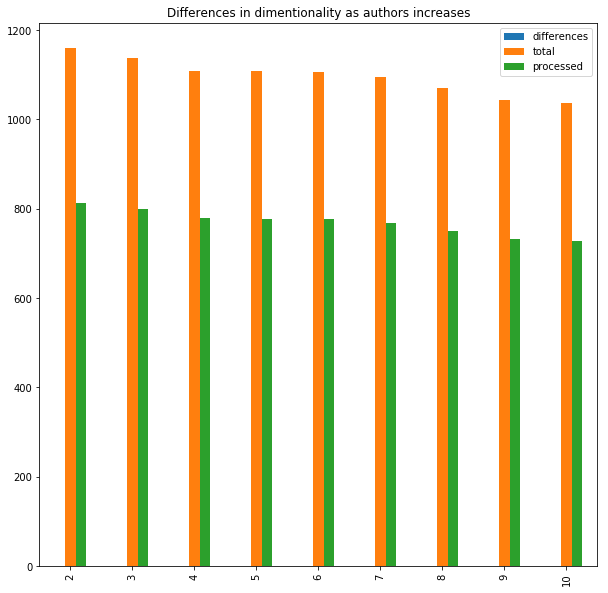

In [62]:
differnces_table.plot.bar(figsize=(10,10), title='Differences in dimentionality as authors increases')

In [63]:
three_author_differences = pd.DataFrame(index=[1,2,3], columns=["total", "processed"])

In [64]:
one_gram_total = pd.read_csv("./3author1grams_post_sparcity.csv", header=0, index_col=0)
one_gram_processed = pd.read_csv("./3author1grams.csv", header=0, index_col=0)
two_gram_total = pd.read_csv("./3author2grams_post_sparcity.csv", header=0, index_col=0)
two_gram_processed = pd.read_csv("./3author2grams.csv", header=0, index_col=0)
three_gram_total = pd.read_csv("./3author3grams_post_sparcity.csv", header=0, index_col=0)
three_gram_processed = pd.read_csv("./3author3grams.csv", header=0, index_col=0)


In [67]:
three_author_differences.at[1, "total"] = len(list(one_gram_total.columns.values))
three_author_differences.at[2, "total"] = len(list(two_gram_total.columns.values))
three_author_differences.at[3, "total"] = len(list(three_gram_total.columns.values))
three_author_differences.at[1, "processed"] = len(list(one_gram_processed.columns.values))
three_author_differences.at[2, "processed"] = len(list(two_gram_processed.columns.values))
three_author_differences.at[3, "processed"] = len(list(three_gram_processed.columns.values))

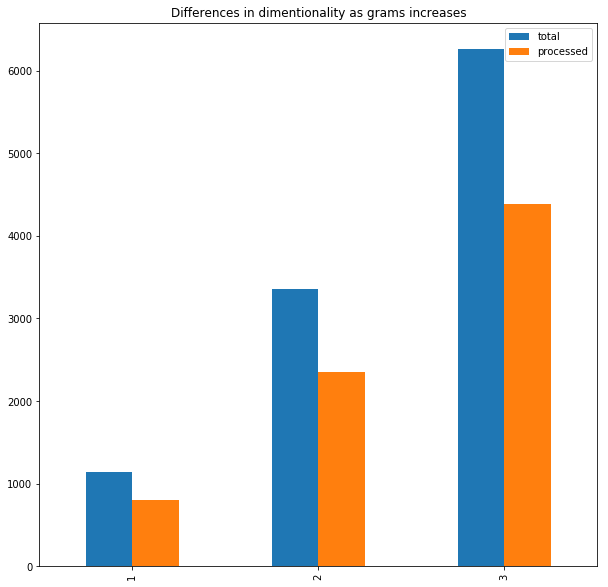

In [70]:
three_author_differences.plot.bar(figsize=(10,10), title='Differences in dimentionality as grams increases')